# Test validity step 2 : $P(s_c | ...) \propto (s_c - s_{c,WF})^t (C^{-1} + (E^t (B^t N^{-1} B)^{-1} E)^{-1}) (s_c - s_{c,WF})$

In [60]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
from jax import random, dtypes
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import numpyro.distributions as dist
import lineax as lx
from lanczos_test import *

import micmac as micmac

In [2]:
PRNGKey = random.PRNGKey(0)


In [3]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Shape for input frequency maps : (6, 2, 49152)
Shape for input cmb maps : (6, 2, 49152)


In [4]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


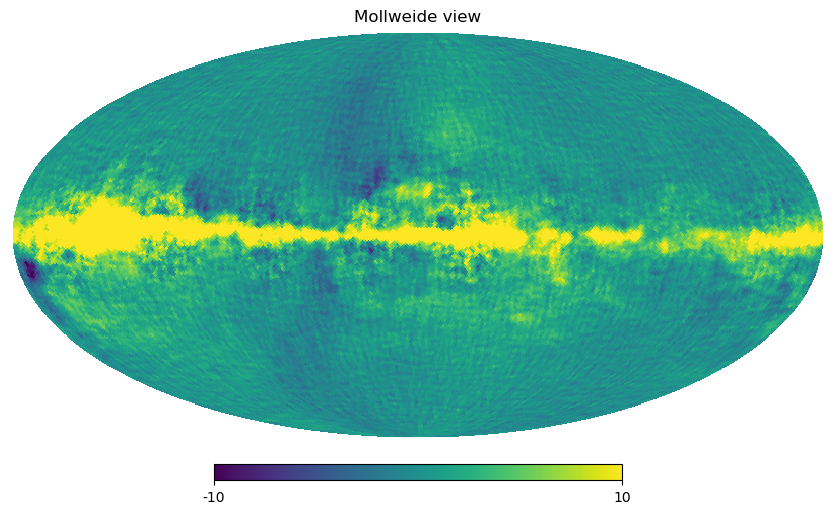

In [5]:
hp.mollview(freq_maps[2,0], min=-10, max=10) # Freq, nstokes, npix

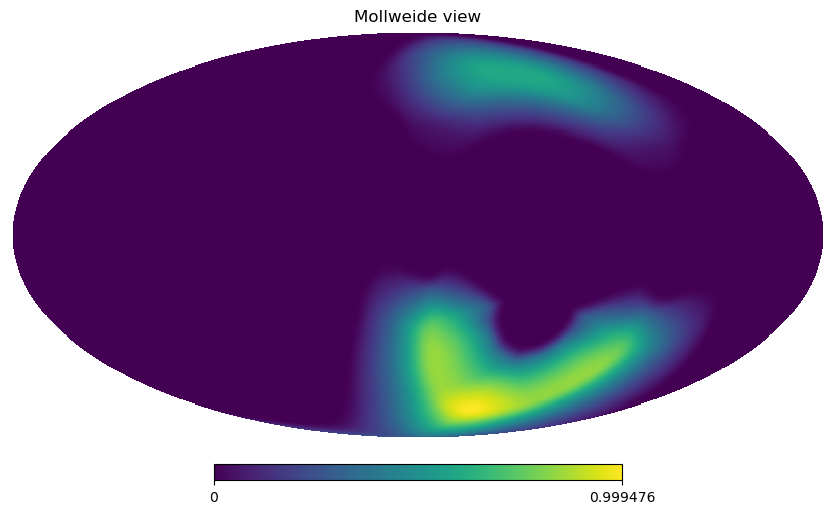

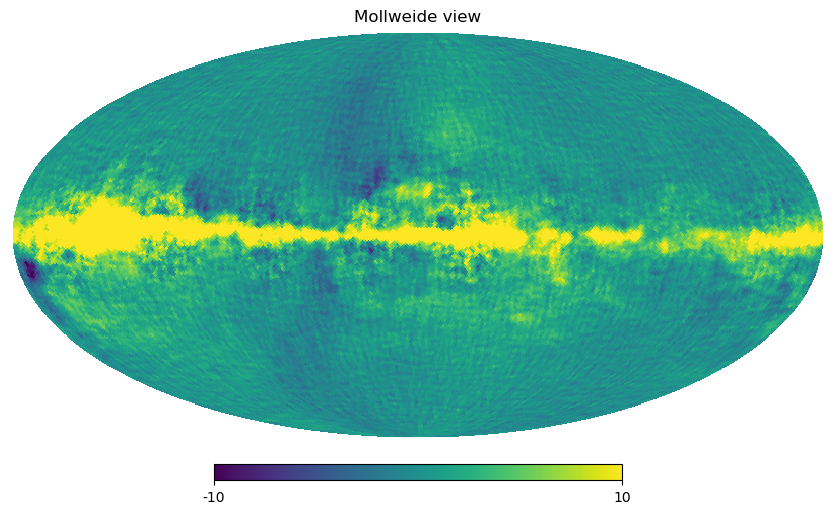

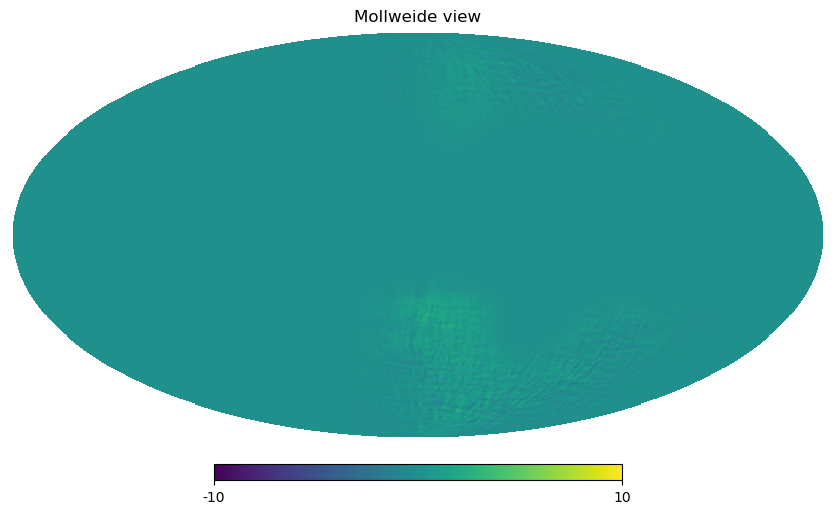

In [6]:
path_mask_test = "/Users/mag/Documents/PHD1Y/Masks/mask_SAT_apodized.fits"

mask_test = hp.read_map(path_mask_test)
hp.mollview(mask_test)
hp.mollview(freq_maps[2,0], min=-10, max=10) # Freq, nstokes, npixhp.mollview(freq_maps[0,0]) # Freq, nstokes, npix
hp.mollview(freq_maps[2,0]*hp.ud_grade(mask_test,nside_out=64), min=-10, max=10) # Freq, nstokes, npix

In [7]:
# working_directory_path = os.path.abspath('') + '/'
working_directory_path = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_chain_v9_JZ/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'


path_toml_file = directory_toml_file + 'corr_fullsky_v1b.toml'


In [8]:
MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)

In [9]:
reduction_noise = 1

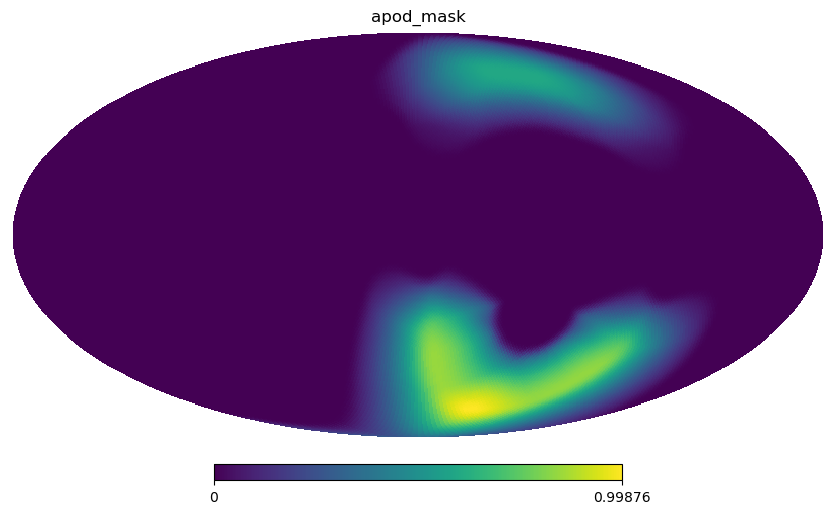

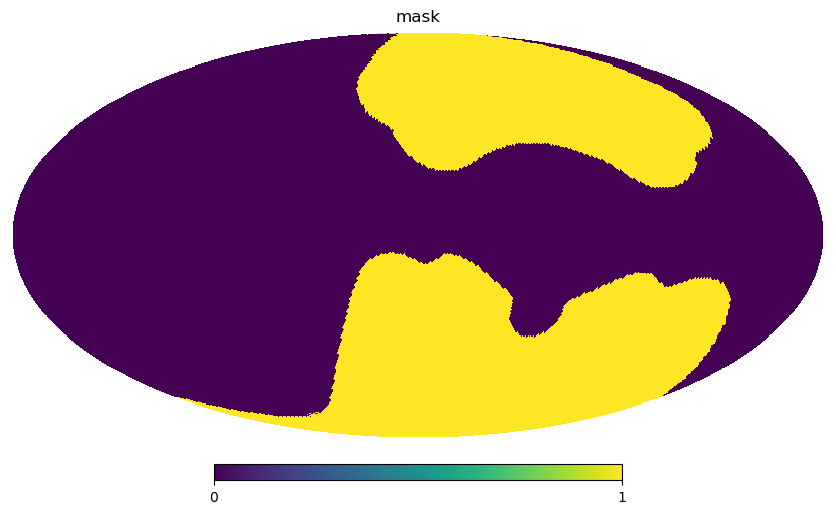

In [10]:
path_mask = "/Users/mag/Documents/PHD1Y/Masks/mask_SAT_apodized.fits"

relative_treshold = 1e-1

apod_mask = hp.ud_grade(hp.read_map(path_mask_test),nside_out=MICMAC_sampler_obj.nside)
mask = np.copy(apod_mask)

mask[apod_mask>0] = 1

hp.mollview(apod_mask, title='apod_mask')

hp.mollview(mask, title='mask')


In [11]:
mask = np.ones(MICMAC_sampler_obj.npix)

MICMAC_sampler_obj.mask = np.array(mask)

In [12]:
# freq_inverse_noise = micmac.get_noise_covar(instrument['depth_p']/reduction_noise, MICMAC_sampler_obj.nside)
freq_inverse_noise_0 = micmac.get_noise_covar(instrument['depth_p'], MICMAC_sampler_obj.nside) #MICMAC_sampler_obj.freq_inverse_noise

freq_inverse_noise_masked = np.zeros((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.npix))

nb_pixels_mask = int(mask.sum())
freq_inverse_noise_masked[:,:,mask!=0] = np.repeat(freq_inverse_noise_0.ravel(order='F'), nb_pixels_mask).reshape((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.number_frequencies,nb_pixels_mask), order='C')

freq_inverse_noise_masked = freq_inverse_noise_masked*mask
# freq_inverse_noise_masked = freq_inverse_noise_masked*nhits_mask

MICMAC_sampler_obj.freq_inverse_noise = freq_inverse_noise_masked
freq_inverse_noise = freq_inverse_noise_masked

In [13]:
instrument = get_instrument(instr_name)

instrument['depth_p'] /= reduction_noise
# get input freq maps

np.random.seed(noise_seed)
freq_maps_fgs = get_observation(instrument, fgs_model, nside=MICMAC_sampler_obj.nside, noise=True)[:, 1:, :]   # keep only Q and U

In [14]:
indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_sampler_obj.nstokes]

In [15]:
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), MICMAC_sampler_obj.number_components, pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs)
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], MICMAC_sampler_obj.number_components, init_params, pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs)

mixing_matrix_sampled = mixing_matrix_obj.get_B()

BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)#*mask
# BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)#*mask
BtinvN_sqrt = micmac.get_BtinvN(np.sqrt(freq_inverse_noise), mixing_matrix_sampled)#*mask

BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)#*mask

nb_pix_mask = int(np.sum(mask))


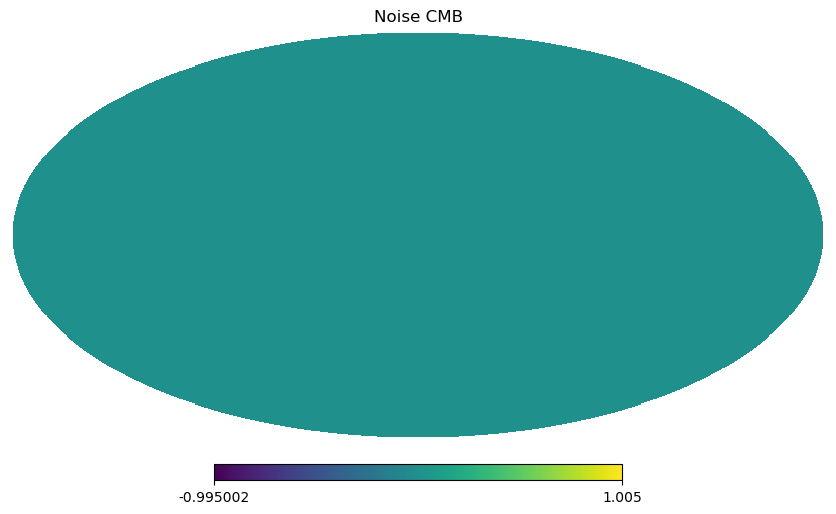

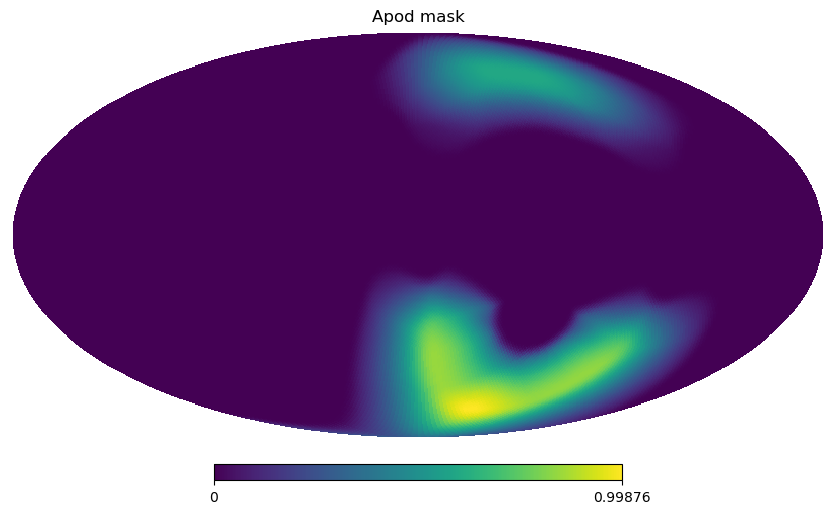

In [16]:
hp.mollview(BtinvNB[0,0], title='Noise CMB')
hp.mollview(apod_mask, title='Apod mask')

In [17]:
input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

input_freq_maps_masked = input_freq_maps*mask
input_cmb_maps = input_cmb_maps*mask

Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [18]:
s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, input_freq_maps_masked, jax_use=False)[0, :, :]

In [19]:
red_cov_matrix_sample = theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor

In [20]:
number_frequencies = MICMAC_sampler_obj.number_frequencies
number_components = MICMAC_sampler_obj.number_components
nstokes = MICMAC_sampler_obj.nstokes
lmin = MICMAC_sampler_obj.lmin
lmax = MICMAC_sampler_obj.lmax
nside = MICMAC_sampler_obj.nside
n_iter = MICMAC_sampler_obj.n_iter
npix = 12*nside**2

In [26]:
N_c_inv = jnp.copy(BtinvNB[0,0])
N_c_inv = N_c_inv.at[...,MICMAC_sampler_obj.mask!=0].set(1/BtinvNB[0,0,MICMAC_sampler_obj.mask!=0]/jhp.nside2resol(MICMAC_sampler_obj.nside)**2)
N_c_inv_repeat = jnp.repeat(N_c_inv.ravel(order='C'), MICMAC_sampler_obj.nstokes).reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix), order='F').ravel()

def second_term_left(x):
    return x*N_c_inv_repeat

red_cov_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix_jax(red_cov_matrix_sample)
first_part_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)), red_cov_matrix_sqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter).ravel()

func = lambda x: x.ravel() + first_part_term_left(second_term_left(first_part_term_left(x)))

right_member = maps_x_red_covariance_cell_JAX(s_cML*N_c_inv, red_cov_matrix_sqrt, nside=nside, lmin=lmin, n_iter=n_iter).ravel()

In [51]:
noise_c_ell = micmac.get_Cl_noise_JAX(np.array(instrument['depth_p']), mixing_matrix_sampled, lmax)[0,0]

red_inv_noise_c_ell = jnp.linalg.pinv(micmac.get_reduced_matrix_from_c_ell_jax(jnp.stack([noise_c_ell, noise_c_ell, jnp.zeros_like(noise_c_ell)])))[lmin:]

red_solution = jnp.linalg.pinv(jnp.eye(nstokes) + jnp.einsum('lij,ljk,lkm->lim', red_cov_matrix_sqrt, red_inv_noise_c_ell, red_cov_matrix_sqrt))

precond_test = lambda x: maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)), red_solution, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter).ravel()

In [55]:
freq_inv_noise_cell = micmac.get_Cl_noise_JAX(np.array(instrument['depth_p']), mixing_matrix_sampled, lmax)

test_freq_noise_cell = get_true_Cl_noise(np.array(instrument['depth_p']), lmax)
noise_c_ell_b = get_inv_BtinvNB_c_ell(test_freq_noise_cell, mixing_matrix_sampled)


# Start of tests

In [59]:
MICMAC_sampler_obj.tolerance_CG = 1e-6
MICMAC_sampler_obj.atol_CG = 1e-8

In [37]:
MICMAC_sampler_obj.limit_iter_cg = 200

In [38]:
initial_guess = np.zeros((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))

In [39]:
%%time

# Test Lineax
func_norm = lambda x : jnp.linalg.norm(x,ord=2)

CG_solver = lx.CG(rtol=MICMAC_sampler_obj.tolerance_CG, atol=MICMAC_sampler_obj.atol_CG, max_steps=MICMAC_sampler_obj.limit_iter_cg, norm=func_norm)

# func_lineax_test = lx.FunctionLinearOperator(func, jax.ShapeDtypeStruct((MICMAC_sampler_obj.nstokes*MICMAC_sampler_obj.npix,),jnp.float64), tags=(lx.symmetric_tag,lx.positive_semidefinite_tag))
func_lineax_test = lx.FunctionLinearOperator(func, jax.ShapeDtypeStruct((MICMAC_sampler_obj.nstokes*MICMAC_sampler_obj.npix,),jnp.float64), tags=(lx.symmetric_tag,lx.positive_semidefinite_tag))

options_dict = {"y0":initial_guess.ravel()}
solution = lx.linear_solve(func_lineax_test, right_member, solver=CG_solver, throw=False, options=options_dict)
# solution = lx.linear_solve(func_lineax_test, s_cML.ravel(), throw=False)
print(solution.stats)

solution_lineax = solution.value.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))

{'max_steps': 200, 'num_steps': Array(200, dtype=int64)}
CPU times: user 57 s, sys: 7.54 s, total: 1min 4s
Wall time: 23 s


In [54]:
%%time

# Test Lineax
func_norm = lambda x : jnp.linalg.norm(x,ord=2)

CG_solver = lx.CG(rtol=MICMAC_sampler_obj.tolerance_CG, atol=MICMAC_sampler_obj.atol_CG, max_steps=MICMAC_sampler_obj.limit_iter_cg, norm=func_norm)

# func_lineax_test = lx.FunctionLinearOperator(func, jax.ShapeDtypeStruct((MICMAC_sampler_obj.nstokes*MICMAC_sampler_obj.npix,),jnp.float64), tags=(lx.symmetric_tag,lx.positive_semidefinite_tag))
func_lineax_test = lx.FunctionLinearOperator(func, jax.ShapeDtypeStruct((MICMAC_sampler_obj.nstokes*MICMAC_sampler_obj.npix,),jnp.float64), tags=(lx.symmetric_tag,lx.positive_semidefinite_tag))

precond_lineax = lx.FunctionLinearOperator(precond_test, jax.ShapeDtypeStruct((MICMAC_sampler_obj.nstokes*MICMAC_sampler_obj.npix,),jnp.float64), tags=(lx.symmetric_tag,lx.positive_semidefinite_tag))

options_dict = {"y0":initial_guess.ravel(), 'preconditioner':precond_lineax}
solution = lx.linear_solve(func_lineax_test, right_member, solver=CG_solver, throw=False, options=options_dict)
# solution = lx.linear_solve(func_lineax_test, s_cML.ravel(), throw=False)
print(solution.stats)

solution_lineax = solution.value.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))

{'max_steps': 200, 'num_steps': Array(3, dtype=int64)}
CPU times: user 3.3 s, sys: 336 ms, total: 3.64 s
Wall time: 2.4 s


In [40]:
%%time
solution_JSP, number_iterations = jsp.sparse.linalg.cg(func, right_member.ravel(), x0=initial_guess.ravel(), tol=MICMAC_sampler_obj.tolerance_CG, maxiter=MICMAC_sampler_obj.limit_iter_cg)

CPU times: user 45 s, sys: 5.85 s, total: 50.8 s
Wall time: 16.2 s


In [52]:
%%time
solution_JSP, number_iterations = jsp.sparse.linalg.cg(func, right_member.ravel(), x0=initial_guess.ravel(), tol=MICMAC_sampler_obj.tolerance_CG, maxiter=MICMAC_sampler_obj.limit_iter_cg, M=precond_test)

CPU times: user 3.04 s, sys: 647 ms, total: 3.69 s
Wall time: 2.19 s


0.0085587487903247 7.46447312849341e-08 0.001559552608300551


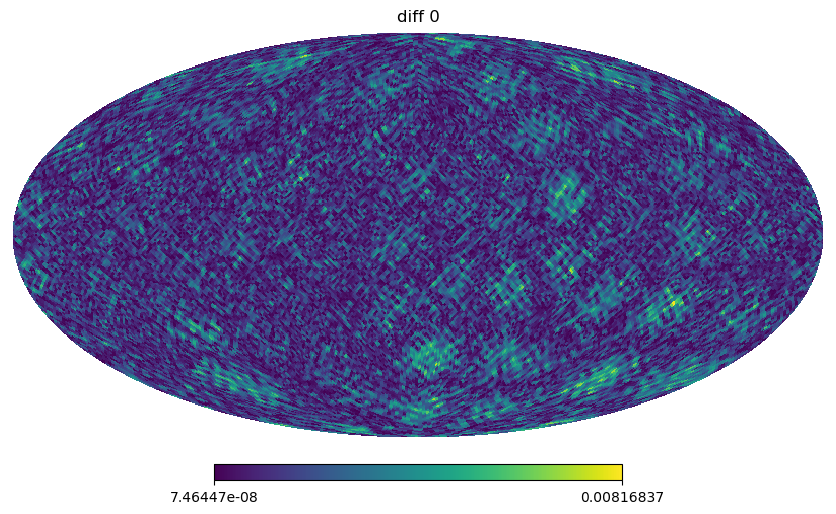

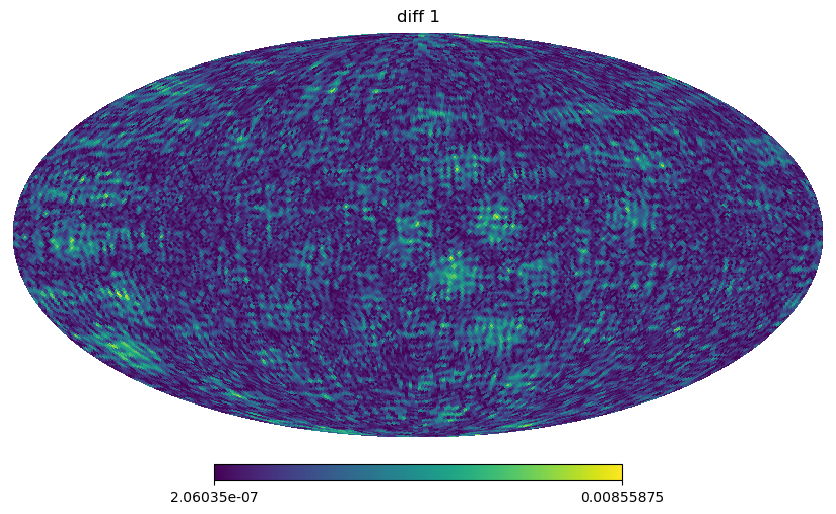

In [41]:
diff = np.abs(solution.value-solution_JSP)

print(diff.max(), diff.min(), diff.mean())
hp.mollview(diff[:MICMAC_sampler_obj.npix], title='diff 0')
hp.mollview(diff[MICMAC_sampler_obj.npix:2*MICMAC_sampler_obj.npix], title='diff 1')

In [42]:
test_solution_custom = jlax.custom_linear_solve(func, b=right_member, symmetric=True)

TypeError: custom_linear_solve() missing 1 required positional argument: 'solve'

In [30]:
@jax.custom_jvp
def f(x, y):
  return jnp.sin(x) * y

# f.nondiff_argnums = (2,)

@f.defjvp
def f_jvp(primals, tangents):
  x, y = primals
  x_dot, y_dot = tangents
  primal_out = f(x, y)
  tangent_out = jnp.cos(x) * x_dot * y + jnp.sin(x) * y_dot
  return primal_out, tangent_out

In [31]:
print(f(2., 3.))
y, y_dot = jax.jvp(f, (2., 3.), (1., 0.))
print(y)
print(y_dot)
print(jax.grad(f)(2., 3.))

2.727892280477045
2.727892280477045
-1.2484405096414273
-1.2484405096414273


In [32]:
@jax.custom_jvp
def func_to_solve(input_map, args=None):
    # BtinvNB = args['BtinvNB']
    # red_cov_matrix_sample = args['red_cov_matrix_sample']
    # N_c_inv = jnp.copy(BtinvNB[0,0])
    # N_c_inv = N_c_inv.at[...,MICMAC_sampler_obj.mask!=0].set(1/BtinvNB[0,0,MICMAC_sampler_obj.mask!=0]/jhp.nside2resol(MICMAC_sampler_obj.nside)**2)
    N_c_inv = jnp.where(MICMAC_sampler_obj.mask!=0, 1/BtinvNB[0,0]/(jhp.nside2resol(MICMAC_sampler_obj.nside)**2), 0)

    N_c_inv_repeat = jnp.repeat(N_c_inv.ravel(order='C'), MICMAC_sampler_obj.nstokes).reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix), order='F').ravel()

    def second_term_left(x):
        return x*N_c_inv_repeat

    red_cov_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix_jax(red_cov_matrix_sample)
    first_part_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)), red_cov_matrix_sqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter).ravel()

    # func = lambda x: maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)), red_cov_matrix_sample, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter).ravel()
    return input_map.ravel() + first_part_term_left(second_term_left(first_part_term_left(input_map.ravel())))

# jv_WF = jax.custom_jvp(func_to_solve, nondiff_argnums=(1,2))

func_to_solve.nondiff_argnums = (1,)

@func_to_solve.defjvp
def func_to_solve_jvp(args, primals, tangents):
    print("Test",primals, args, tangents, flush=True)
    input_map = primals[0]
    input_map_dot = tangents[0]

    # N_c_inv = jnp.copy(BtinvNB[0,0])
    # N_c_inv = N_c_inv.at[...,MICMAC_sampler_obj.mask!=0].set(1/BtinvNB[0,0,MICMAC_sampler_obj.mask!=0]/jhp.nside2resol(MICMAC_sampler_obj.nside)**2)
    # N_c_inv_repeat = jnp.repeat(N_c_inv.ravel(order='C'), MICMAC_sampler_obj.nstokes).reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix), order='F').ravel()

    # def second_term_left(x):
    #     return x*N_c_inv_repeat

    # red_cov_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix_jax(red_cov_matrix_sample)
    # first_part_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)), red_cov_matrix_sqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter).ravel()

    # func = lambda x: maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)), red_cov_matrix_sample, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter).ravel()
    return func_to_solve(input_map), func_to_solve(input_map_dot)

In [37]:
MICMAC_sampler_obj.tolerance_CG = 1e-6
# MICMAC_sampler_obj.limit_iter_cg = 2000

In [23]:
%%time
PRNGKey = random.PRNGKey(0)
map_random_realization_xi = None
map_random_realization_chi = None
fluctuation_maps_v2c = MICMAC_sampler_obj.get_fluctuating_term_maps_v2c(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey, 
                                                                        map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, 
                                                                        initial_guess=jnp.empty(0))


Recalculating xi !
Recalculating chi !
CG Fluct finished in  10.60972809791565 seconds !!
CG-Python-0 Fluct finished with  lineax._solution.RESULTS<The maximum number of solver steps was reached. Try increasing `max_steps`.> {'max_steps': 200, 'num_steps': Array(200, dtype=int64)}
CPU times: user 1min 4s, sys: 7.59 s, total: 1min 11s
Wall time: 14 s


In [24]:
jitted_get_fluctuating_term_maps_v2c = jax.jit(MICMAC_sampler_obj.get_fluctuating_term_maps_v2c)

In [26]:
%%time
wiener_filter_term_v2c = MICMAC_sampler_obj.solve_generalized_wiener_filter_term_v2c(s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=jnp.empty(0))


CG-Python-0 Fluct finished with  lineax._solution.RESULTS<The maximum number of solver steps was reached. Try increasing `max_steps`.> {'max_steps': 200, 'num_steps': Array(200, dtype=int64)}
CPU times: user 56.1 s, sys: 6.98 s, total: 1min 3s
Wall time: 11.6 s


In [27]:
jitted_solve_generalized_wiener_filter_term_v2c = jax.jit(MICMAC_sampler_obj.solve_generalized_wiener_filter_term_v2c)

In [28]:
# %%time
# wiener_filter_term_v2c = jitted_solve_generalized_wiener_filter_term_v2c(s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=jnp.empty(0))


In [33]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

In [34]:
_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, lmax)[0,0,lmin:]
red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

In [35]:
fsky = mask.sum()/mask.size
fsky = 1#mask.sum()/mask.size

/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


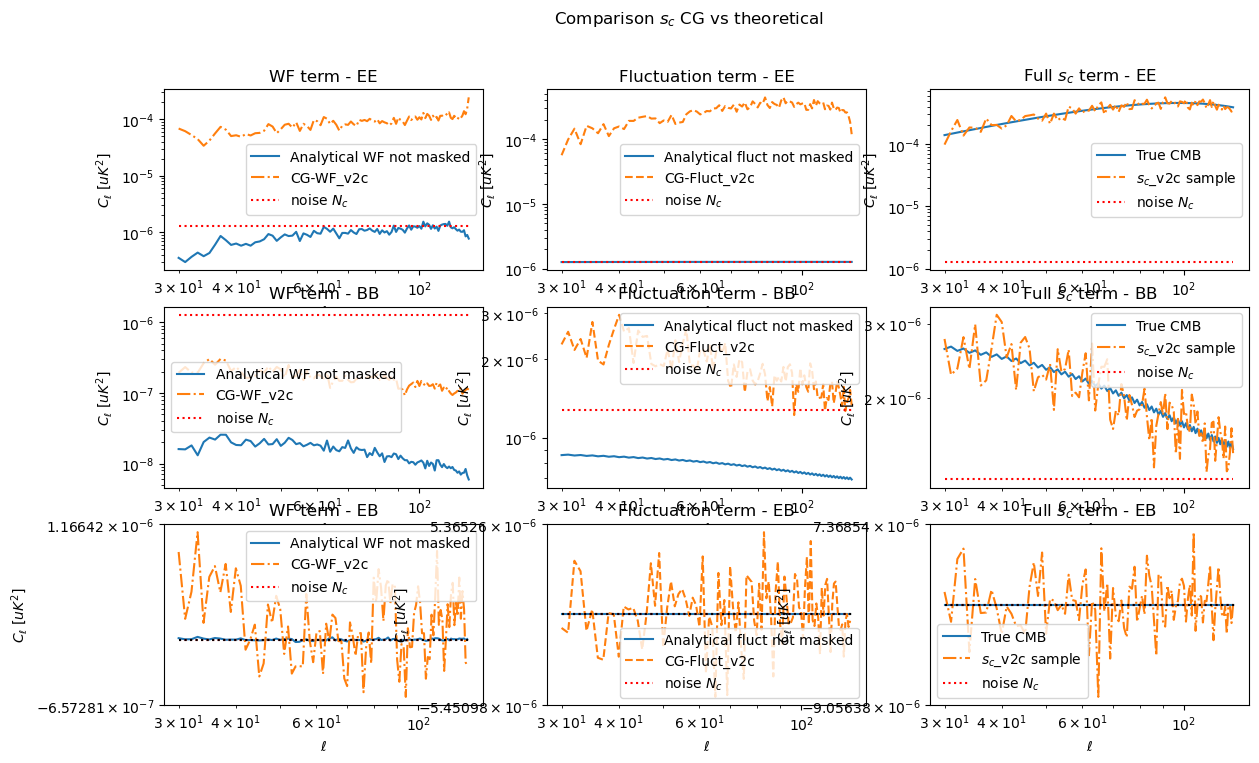

In [36]:
list_correl = ['EE', 'BB', 'EB']

c_ell_true_CMB = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor)

covariance_noise = np.zeros_like(c_ell_true_CMB)

# analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix_sample) + np.eye(nstokes)/BtinvNB[0,0])
# # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
# analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0], analytical_WF_harm, lmin=lmin, n_iter=n_iter)
analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix_sample) + np.linalg.pinv(red_cl_noise_harm))
# analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
N_c_inv = jnp.copy(BtinvNB[0,0])
N_c_inv = N_c_inv.at[...,mask!=0].set(1/BtinvNB[0,0,mask!=0]/jhp.nside2resol(nside)**2)

# analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0]/hp.nside2resol(MICMAC_sampler_obj.nside)**2,
#                                                                         analytical_WF_harm, lmin=lmin, n_iter=n_iter)

s_cML_unmasked = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, input_freq_maps, jax_use=False)[0, :, :]
analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML_unmasked/BtinvNB[0,0,mask!=0][0]/hp.nside2resol(MICMAC_sampler_obj.nside)**2,
                                                                        analytical_WF_harm, lmin=lmin, n_iter=n_iter)

analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]


s_c_WF_v2c_maps_extended = np.vstack([np.zeros_like(wiener_filter_term_v2c[0,...]), wiener_filter_term_v2c])
c_ells_s_c_WF_v2c = hp.anafast(s_c_WF_v2c_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_fluct_v2c_maps_extended = np.vstack([np.zeros_like(fluctuation_maps_v2c[0,...]), fluctuation_maps_v2c])
c_ells_s_c_fluct_v2c = hp.anafast(s_c_fluct_v2c_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_sample_v2c = wiener_filter_term_v2c + fluctuation_maps_v2c
s_c_v2c_recovered_ext = np.vstack([np.zeros_like(s_c_sample_v2c[0]),s_c_sample_v2c])
c_ells_s_c_v2c = hp.anafast(s_c_v2c_recovered_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

plt.figure(figsize=(14,8))
plt.suptitle(r"Comparison $s_c$ CG vs theoretical")

for j in range(number_correl_to_plot):
    plt.subplot(331+3*j)
    plt.plot(np.arange(c_ells_s_c_WF_v2c.shape[-1])+lmin, analytical_WF_cells[j,:], label='Analytical WF not masked')
    plt.plot(np.arange(c_ells_s_c_WF_v2c.shape[-1])+lmin, c_ells_s_c_WF_v2c[j,:]/fsky, '-.', label='CG-WF_v2c')
    plt.plot(np.arange(c_ells_s_c_WF_v2c.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')
    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('WF term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()

    plt.subplot(332+3*j)
    plt.plot(np.arange(c_ells_s_c_fluct_v2c.shape[-1])+lmin, analytical_fluct_c_ell[j,:], label='Analytical fluct not masked')
    plt.plot(np.arange(c_ells_s_c_fluct_v2c.shape[-1])+lmin, c_ells_s_c_fluct_v2c[j,:]/fsky, '--', label='CG-Fluct_v2c')
    plt.plot(np.arange(c_ells_s_c_fluct_v2c.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Fluctuation term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()
    
    plt.subplot(333+3*j)
    plt.plot(np.arange(c_ells_s_c_v2c.shape[-1])+lmin, c_ell_true_CMB[j,:], label='True CMB')
    plt.plot(np.arange(c_ells_s_c_v2c.shape[-1])+lmin, c_ells_s_c_v2c[j,:]/fsky, '-.', label='$s_c$_v2c sample')
    plt.plot(np.arange(c_ells_s_c_v2c.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

    if j <= nstokes-1:
        plt.loglog()
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    
    plt.xlabel(r"$\ell$")
    plt.legend()


plt.show()